In [1]:
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import gaussian_kde
import sys
from tqdm import tqdm
import torch

# Set up path to import from src
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import pokie from pokie.py
# from new_pokie import pokie, pokie_bootstrap
from pokie import pokie, pokie_bootstrap, get_device

# Sample from GMM

In [2]:
def generate_samples_from_gmm(means, covariances, n_samples):
    """
    means:       shape (n_components, n_dimensions)
    covariances: shape (n_components, n_dimensions),
                 each row is the diagonal of the covariance matrix for that component
    n_samples:   number of samples to generate in total
    """
    n_components, n_dimensions = means.shape
    samples = np.zeros((n_samples, n_dimensions))
    # Assume uniform mixing weights for simplicity
    component_choices = np.random.choice(
        n_components, size=n_samples, p=np.ones(n_components)/n_components
    )

    for i, comp in enumerate(component_choices):
        # Use np.diag(...) so each component's covariance is diagonal
        cov = np.diag(covariances[comp])
        samples[i, :] = np.random.multivariate_normal(means[comp], cov)
    return samples

# 2 Dimension

In [3]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 2
n_truth_samples = 1000  # Number of ground truth samples
num_posterior_samples = 1000  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"

epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:00<00:00, 37.63it/s]


In [4]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

# Convert to torch Tensors on the chosen device
truth_data_normalized   = torch.tensor(truth_data_normalized, dtype=torch.float32, device=device)
models_normalized = torch.tensor(models_normalized,   dtype=torch.float32, device=device)

results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs = 100)

# Convert results, calibrated, n_over_N_vals back to numpy arrays
results = results.cpu().numpy()
calibrated = calibrated.cpu().numpy()
n_over_N_vals = n_over_N_vals.cpu().numpy()

print('\nShift Magnitudes:', shift_magnitudes)
print('Results:', results)
print('Calibrated:', calibrated)

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:01<00:00, 82.41it/s]



Shift Magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Results: [0.04238699 0.04341909 0.04475915 0.04600145 0.04730479 0.04871413
 0.0497317  0.05066142 0.05131752 0.05184283 0.05217006 0.05224252
 0.05161673 0.05072654 0.0494655  0.04816398 0.04655084 0.04507999
 0.04376704 0.04253909 0.04153863]
Calibrated: [0.5406984  0.55386406 0.57095814 0.58680516 0.603431   0.62140894
 0.6343891  0.64624894 0.6546182  0.66131943 0.6654935  0.66641784
 0.6584351  0.64707965 0.6309935  0.614391   0.5938134  0.57505083
 0.5583025  0.54263866 0.5298765 ]


# 2D GMM Plots

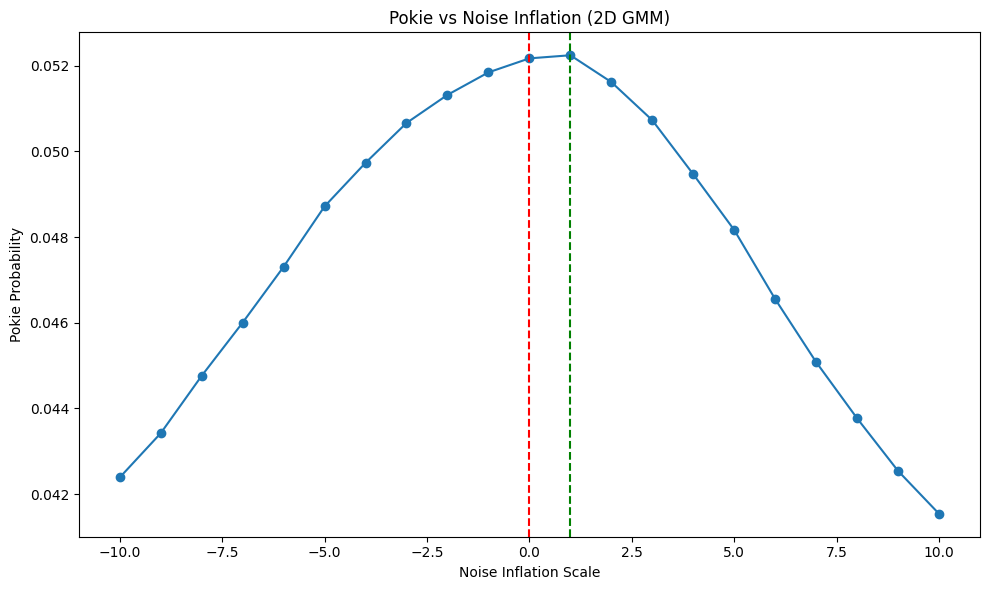

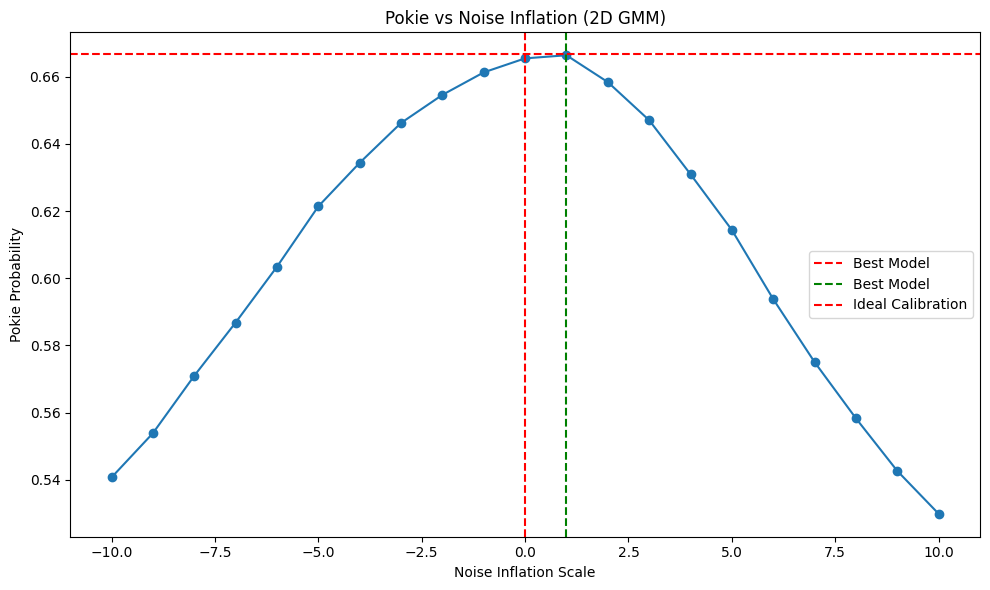

In [5]:
# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

# Plot Pokie vs noise level
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (2D GMM)')
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_2D_GMM.pdf")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (2D GMM)')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_2D_GMM_Calibrated.pdf")
plt.show()

# 2 Dimensional n/N Distribution Plots

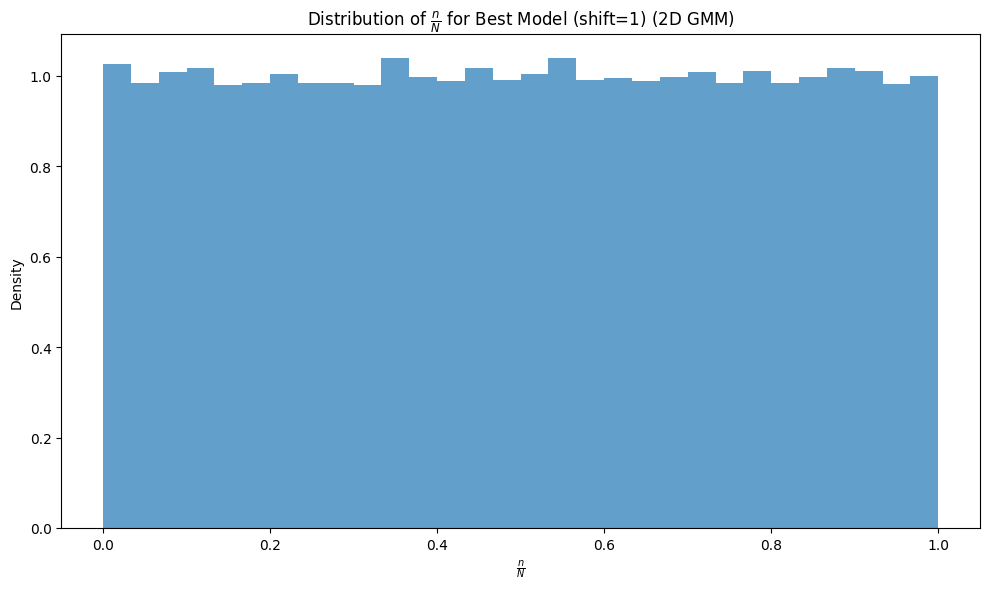

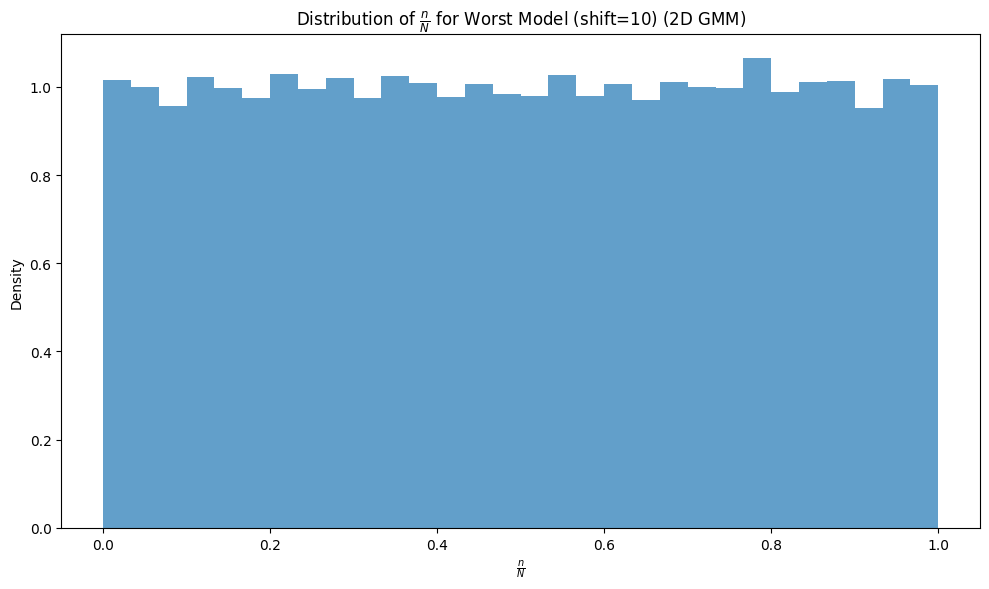

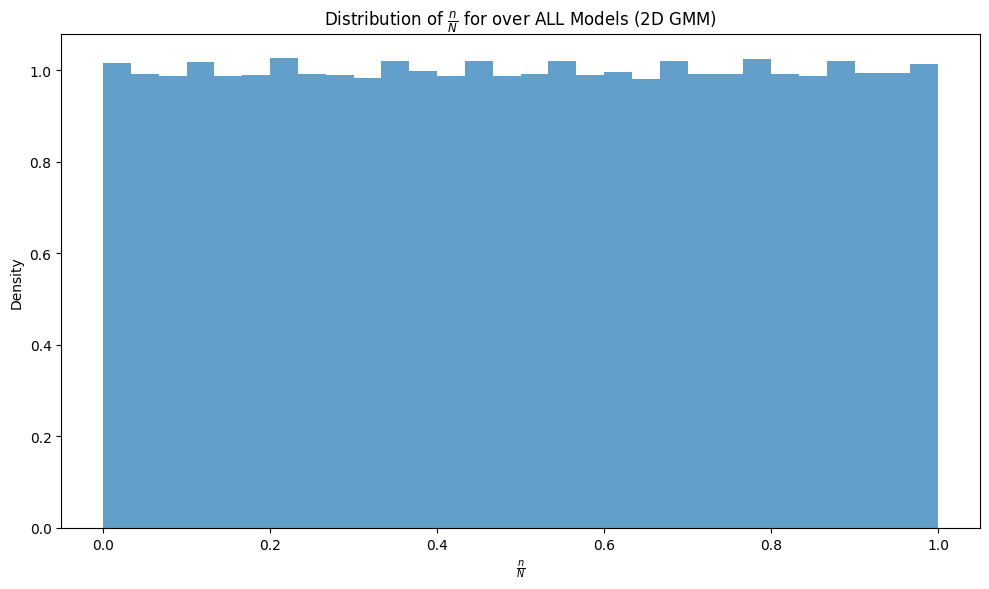

In [6]:
# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (2D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_Best_Model_n_over_N_2D_GMM.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (2D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_Worst_Model_n_over_N_2D_GMM.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models (2D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_n_over_N_2D_GMM.pdf")
plt.show()

# 20 Dimensions

In [7]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 10
n_truth_samples = 500  # Number of ground truth samples
num_posterior_samples = 500  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"

epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:00<00:00, 70.51it/s]


In [8]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

# Convert to torch Tensors on the chosen device
truth_data_normalized   = torch.tensor(truth_data_normalized, dtype=torch.float32, device=device)
models_normalized = torch.tensor(models_normalized,   dtype=torch.float32, device=device)

results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs = 100)

# Convert results, calibrated, n_over_N_vals back to numpy arrays
results = results.cpu().numpy()
calibrated = calibrated.cpu().numpy()
n_over_N_vals = n_over_N_vals.cpu().numpy()

print('\nShift Magnitudes:', shift_magnitudes)
print('Results:', results)
print('Calibrated:', calibrated)

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:00<00:00, 119.67it/s]



Shift Magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Results: [0.04270005 0.04285287 0.04260301 0.0431349  0.04395942 0.04571103
 0.04909815 0.05276357 0.05517718 0.05638925 0.05677786 0.05637448
 0.05433979 0.05082408 0.04803204 0.04486463 0.04340402 0.04309621
 0.04271125 0.04244412 0.04274211]
Calibrated: [0.50149417 0.503289   0.50035447 0.5066013  0.51628494 0.53685683
 0.5766372  0.61968595 0.64803284 0.66226804 0.66683215 0.6620945
 0.638198   0.59690744 0.56411606 0.52691627 0.509762   0.5061469
 0.5016258  0.4984883  0.50198823]


# 20D GMM Plots

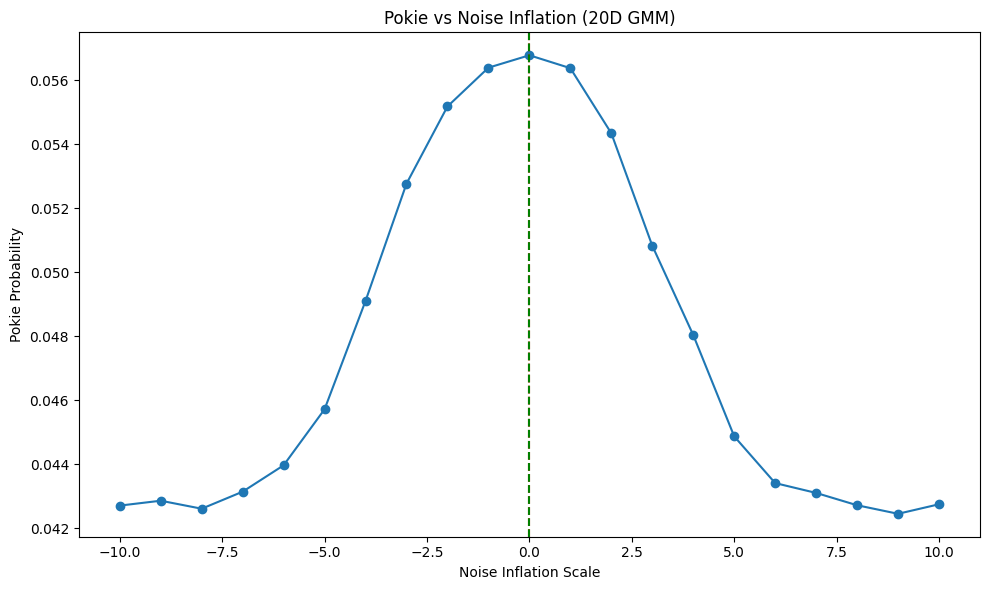

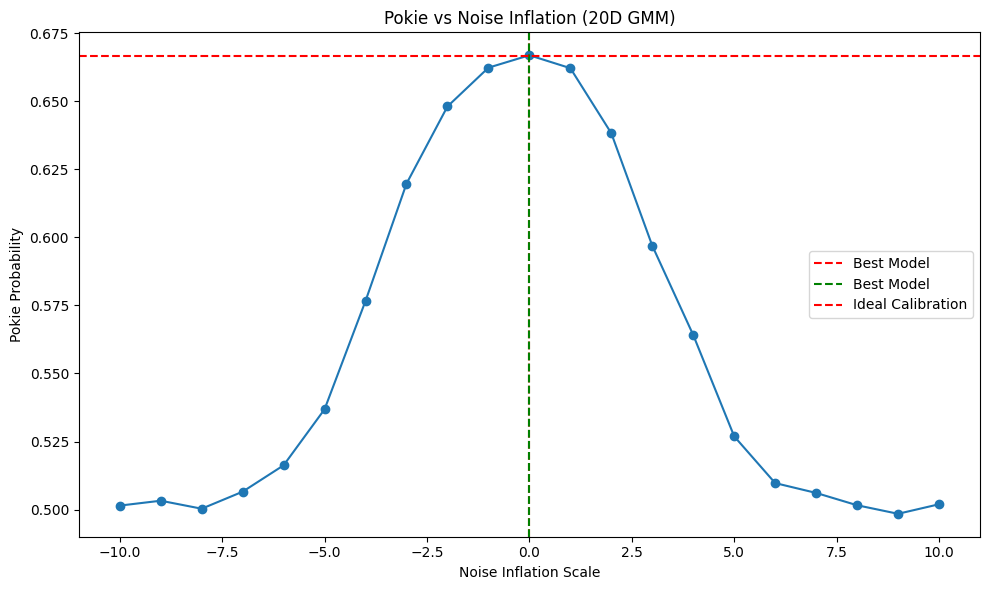

In [9]:
# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

# Plot Pokie vs noise level
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (20D GMM)')
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_20D_GMM.pdf")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (20D GMM)')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_20D_GMM_Calibrated.pdf")
plt.show()

# 20 Dimensional n/N Distribution Plots

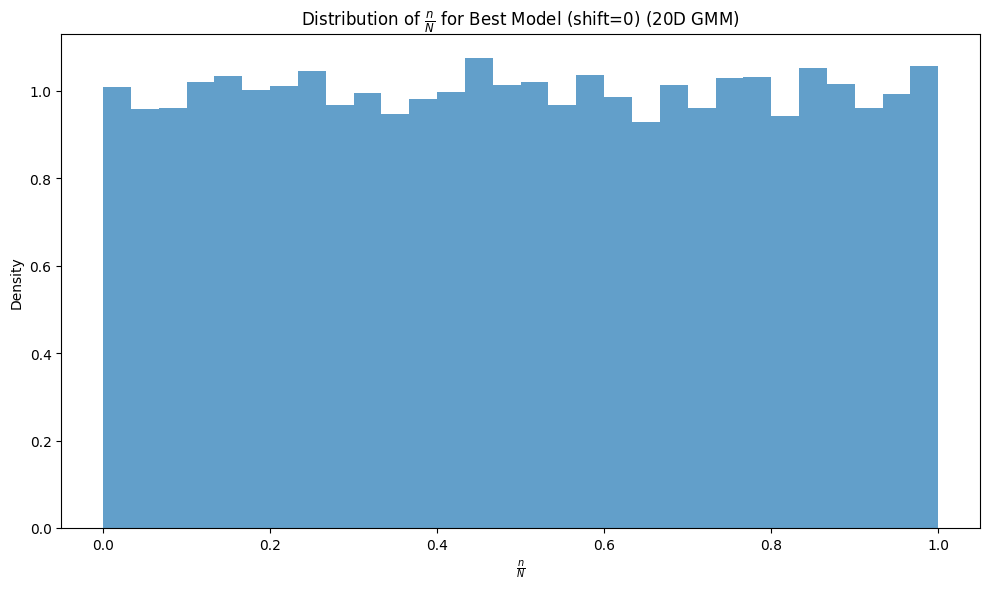

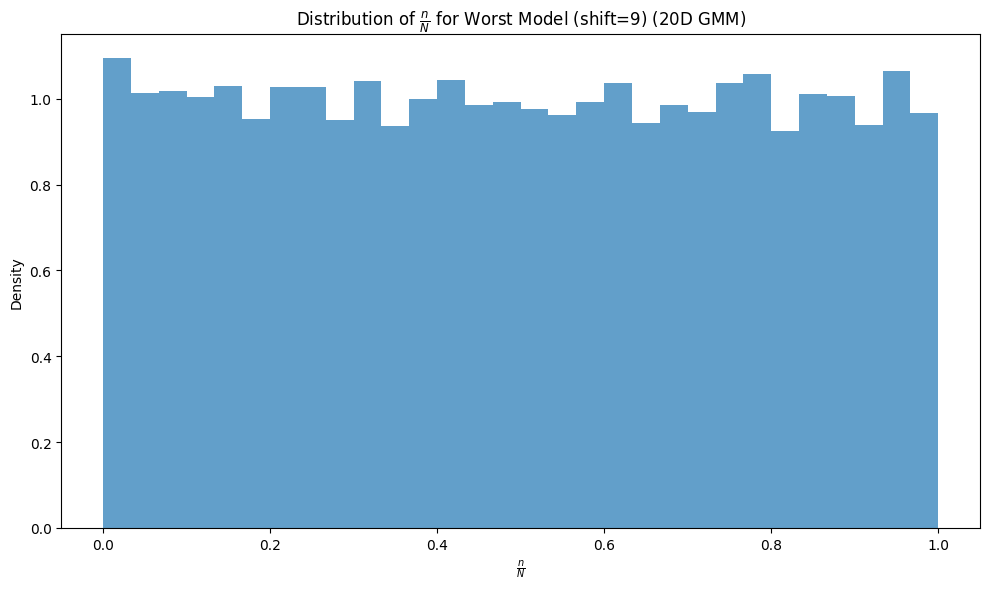

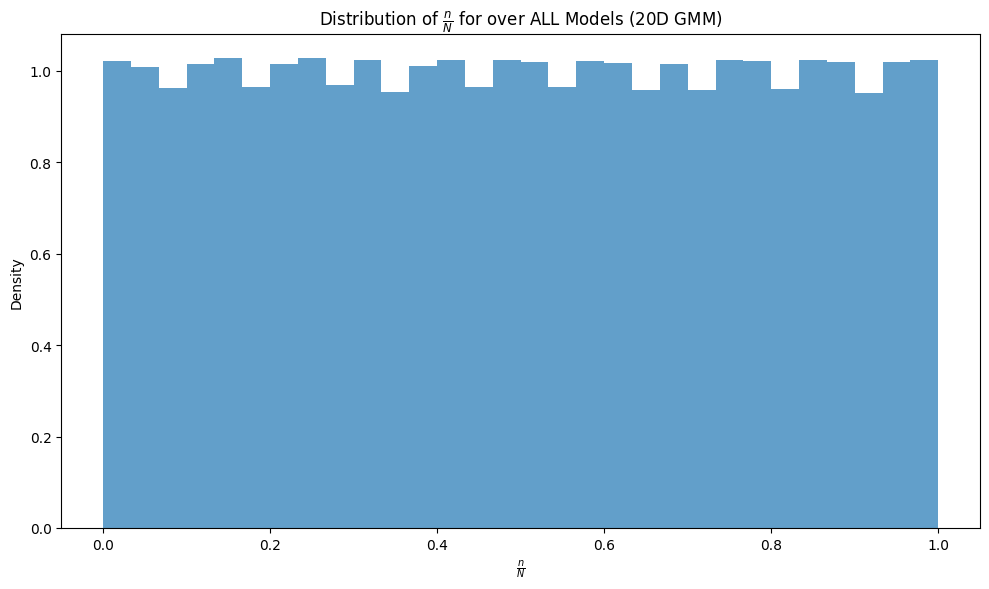

In [10]:
# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_Best_Model_n_over_N_20D_GMM.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_Worst_Model_n_over_N_20D_GMM.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_n_over_N_20D_GMM.pdf")
plt.show()

# 100 Dimension

In [11]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 100
n_truth_samples = 500  # Number of ground truth samples
num_posterior_samples = 500  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"

epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


In [12]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

# Convert to torch Tensors on the chosen device
truth_data_normalized   = torch.tensor(truth_data_normalized, dtype=torch.float32, device=device)
models_normalized = torch.tensor(models_normalized,   dtype=torch.float32, device=device)

results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs = 100)

# Convert results, calibrated, n_over_N_vals back to numpy arrays
results = results.cpu().numpy()
calibrated = calibrated.cpu().numpy()
n_over_N_vals = n_over_N_vals.cpu().numpy()

print('\nShift Magnitudes:', shift_magnitudes)
print('Results:', results)
print('Calibrated:', calibrated)

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [10:42<00:00,  6.42s/it]



Shift Magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Results: [0.04519032 0.04517718 0.04497001 0.04475071 0.0451183  0.0448735
 0.04508399 0.0456204  0.05101889 0.0586661  0.05995308 0.0585537
 0.05126788 0.04556644 0.04492693 0.04494615 0.04490074 0.04500493
 0.0446498  0.0448952  0.04486573]
Calibrated: [0.50335944 0.5032131  0.5009056  0.49846277 0.5025573  0.4998305
 0.5021751  0.5081499  0.568282   0.65346164 0.66779685 0.6522095
 0.5710555  0.5075489  0.50042564 0.50063974 0.5001339  0.50129455
 0.49733883 0.50007224 0.49974403]


# 100D GMM Plots

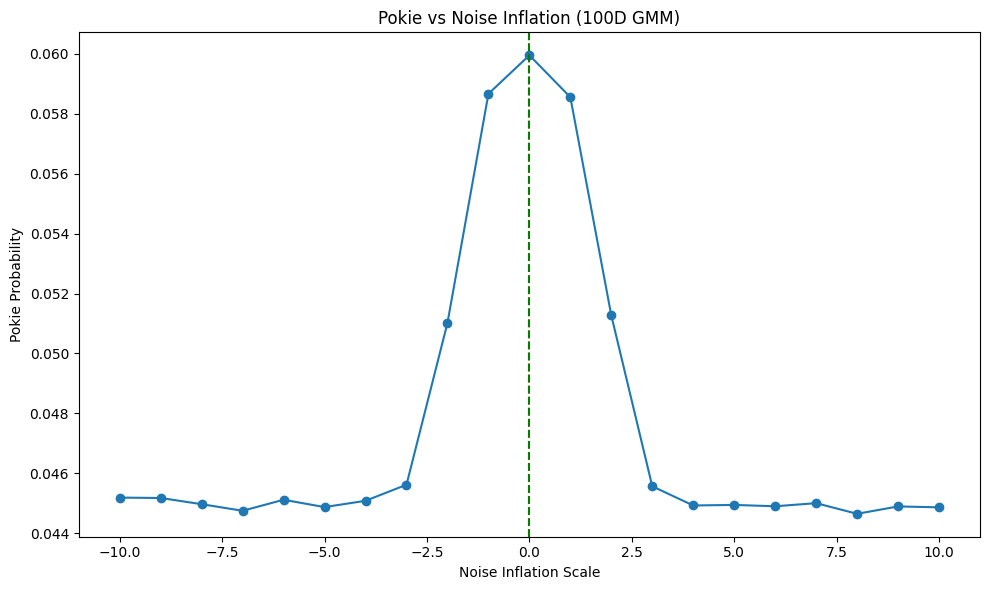

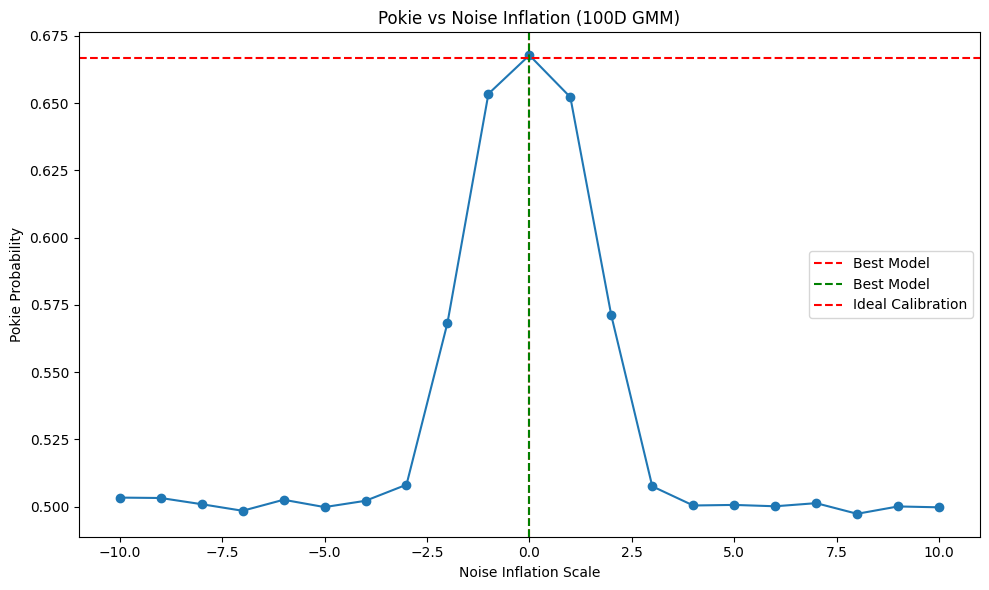

In [13]:
# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

# Plot Pokie vs noise level
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (100D GMM)')
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_100D_GMM.pdf")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (100D GMM)')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_100D_GMM_Calibrated.pdf")
plt.show()

# 100 Dimensional n/N Distribution Plots

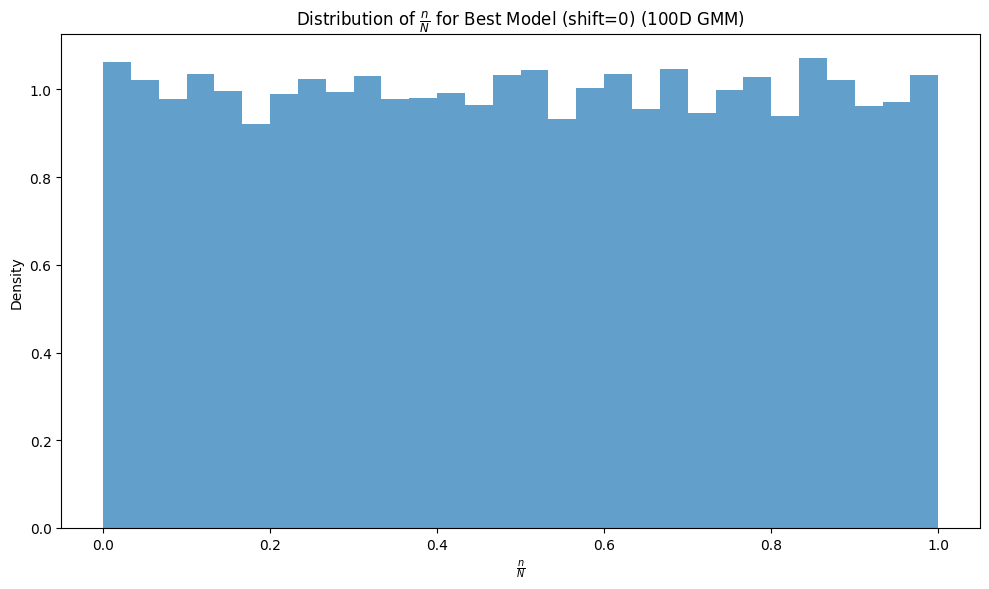

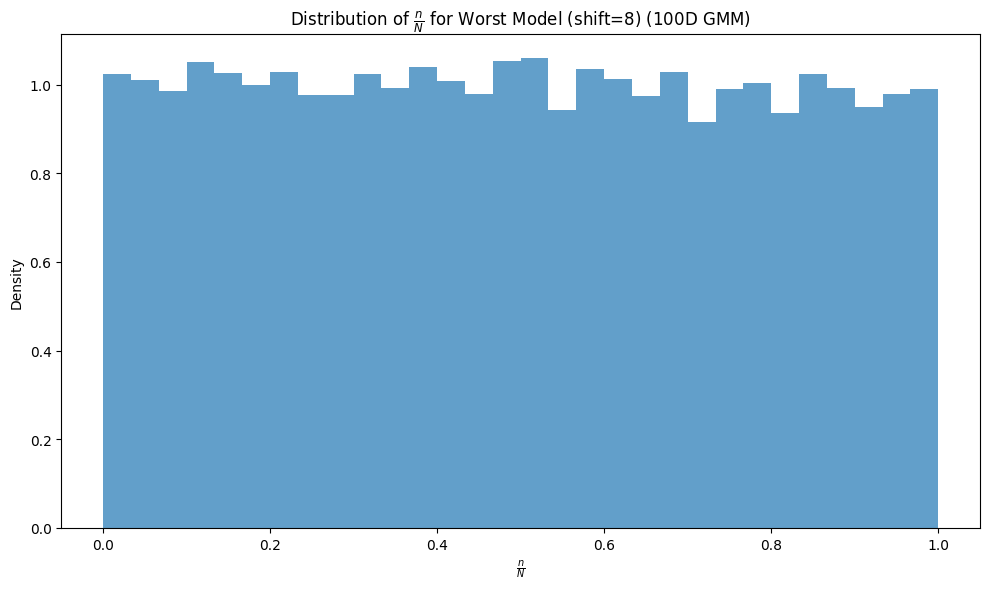

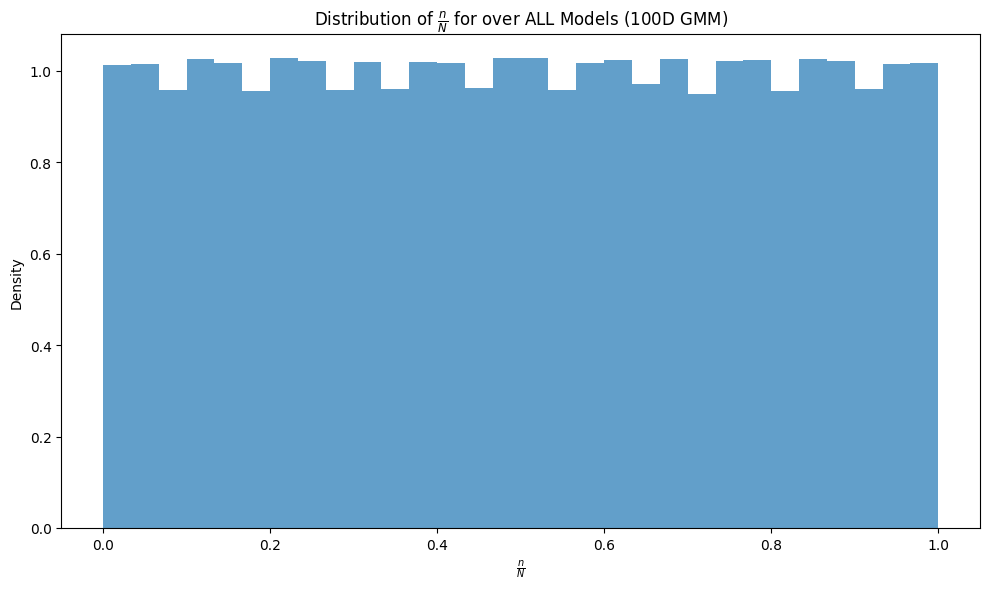

In [14]:
# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_Best_Model_n_over_N_100D_GMM.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_Worst_Model_n_over_N_100D_GMM.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_n_over_N_100D_GMM.pdf")
plt.show()